In [1]:
# 1. Install Dependencies
%pip install pandas scikit-learn requests joblib tqdm matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 2. Fetch Comprehensive Training Data from openFDA (Optimized)
import requests
import pandas as pd
import time
import os
from tqdm import tqdm

# Ensure directories exist
os.makedirs('../analysis/results', exist_ok=True)
os.makedirs('../models', exist_ok=True)

def collect_faers_samples_robust():
    # Expanded list including Generics AND Common Brand Names
    drugs = [
        # Cardiovascular
        "atorvastatin", "lipitor", "lisinopril", "zestril", "amlodipine", "norvasc",
        "metoprolol", "lopressor", "losartan", "cozaar", "hydrochlorothiazide", "microzide",
        "furosemide", "lasix", "carvedilol", "coreg", "clopidogrel", "plavix",
        "warfarin", "coumadin", "apixaban", "eliquis", "rivaroxaban", "xarelto",
        
        # Endocrine
        "levothyroxine", "synthroid", "metformin", "glucophage", "insulin", "lantus", "humalog",
        
        # Pain / CNS
        "gabapentin", "neurontin", "sertraline", "zoloft", "trazodone", "desyrel",
        "escitalopram", "lexapro", "duloxetine", "cymbalta", "alprazolam", "xanax",
        "clonazepam", "klonopin", "lorazepam", "ativan", "zolpidem", "ambien",
        "tramadol", "ultram", "oxycodone", "percocet", "hydrocodone", "vicodin",
        "ibuprofen", "advil", "motrin", "naproxen", "aleve", "acetaminophen", "tylenol",
        "aspirin", "bayer",
        
        # Respiratory / Allergy
        "albuterol", "ventolin", "proair", "fluticasone", "flonase", "montelukast", "singulair",
        "prednisone", "deltasone",
        
        # GI
        "omeprazole", "prilosec", "pantoprazole", "protonix", "famotidine", "pepcid",
        
        # Antibiotics
        "amoxicillin", "augmentin", "azithromycin", "zithromax", "ciprofloxacin", "cipro",
        "cephalexin", "keflex", "doxycycline", "vibramycin"
    ]
    
    # Expanded list of symptoms (Common + Serious Adverse Events)
    symptoms = [
        # Critical / Life-Threatening
        "myocardial infarction", "heart attack", "cardiac arrest", "stroke", "cerebrovascular accident",
        "anaphylactic reaction", "anaphylaxis", "angioedema", "stevens-johnson syndrome",
        "renal failure", "kidney failure", "hepatic failure", "liver failure",
        "respiratory failure", "pulmonary embolism", "deep vein thrombosis",
        "gastrointestinal haemorrhage", "internal bleeding", "seizure", "convulsion",
        "suicidal ideation", "rhabdomyolysis", "pancreatitis", "sepsis",
        
        # Moderate / Common
        "chest pain", "dyspnoea", "shortness of breath", "dizziness", "vertigo",
        "palpitations", "tachycardia", "bradycardia", "hypertension", "hypotension",
        "syncope", "fainting", "oedema", "swelling", "rash", "urticaria", "hives",
        "pruritus", "itching", "vomiting", "nausea", "diarrhoea", "abdominal pain",
        "headache", "migraine", "tremor", "insomnia", "anxiety", "depression",
        "fatigue", "asthenia", "weakness", "pyrexia", "fever", "arthralgia", "joint pain",
        "myalgia", "muscle pain", "back pain", "cough"
    ]
    
    samples = []
    base_url = "https://api.fda.gov/drug/event.json"
    
    print(f"🚀 Starting optimized data collection...")
    print(f"   Target: {len(drugs)} drugs. We will fetch ALL reactions per drug in one go.")
    
    # Use tqdm for a progress bar
    for drug in tqdm(drugs, desc="Processing Drugs"):
        # OPTIMIZATION: Instead of 64 calls per drug, we make 1 call per drug
        # We ask openFDA to count the top 1000 reactions for this drug
        query = f'patient.drug.medicinalproduct:"{drug}"'
        params = {
            'search': query,
            'count': 'patient.reaction.reactionmeddrapt.exact',
            'limit': 1000
        }
        
        try:
            response = requests.get(base_url, params=params, timeout=10)
            
            # Handle rate limits
            if response.status_code == 429:
                time.sleep(5) # Wait longer if hit limit
                # Retry once
                response = requests.get(base_url, params=params, timeout=10)

            data = response.json()
            
            # Create a lookup dictionary for this drug's reactions
            # Format: {'headache': 500, 'nausea': 200, ...}
            reaction_counts = {}
            if 'results' in data:
                for item in data['results']:
                    reaction_counts[item['term'].lower()] = item['count']
            
            # Now check our specific target symptoms against this lookup
            for symptom in symptoms:
                symptom_lower = symptom.lower()
                
                # Get count from lookup (0 if not found in top 1000)
                count = reaction_counts.get(symptom_lower, 0)
                
                # Refined Labeling Logic
                if count > 2000:
                    label = 2  # Critical / High Association
                elif count > 300:
                    label = 1  # Moderate Association
                else:
                    label = 0  # Low / Rare Association
                
                samples.append({
                    'drug': drug,
                    'symptom': symptom,
                    'faers_reports': count,
                    'label': label
                })
                    
        except Exception as e:
            # If error (e.g. drug not found), assume 0 for all symptoms
            for symptom in symptoms:
                samples.append({'drug': drug, 'symptom': symptom, 'faers_reports': 0, 'label': 0})
            continue
        
        # Small delay to be polite to the API
        time.sleep(0.25)
    
    return pd.DataFrame(samples)

# Run collection
df = collect_faers_samples_robust()

# Save raw data
df.to_csv('../analysis/results/training_data_robust.csv', index=False)

print(f"\n✅ Data Collection Complete!")
print(f"   Total Samples: {len(df)}")
print(f"   Class Distribution:\n{df['label'].value_counts().sort_index()}")
df.head()

🚀 Starting optimized data collection...
   Target: 89 drugs. We will fetch ALL reactions per drug in one go.


Processing Drugs: 100%|████████████████████████████████████████████████| 89/89 [05:04<00:00,  3.42s/it]


✅ Data Collection Complete!
   Total Samples: 5696
   Class Distribution:
label
0    2333
1    1935
2    1428
Name: count, dtype: int64


,drug,symptom,faers_reports,label
0,atorvastatin,myocardial infarction,4625,2
1,atorvastatin,heart attack,0,0
2,atorvastatin,cardiac arrest,1915,1
3,atorvastatin,stroke,0,0
4,atorvastatin,cerebrovascular accident,4373,2


🔧 Preprocessing Data...

🔍 Starting Grid Search for Best Model...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

🏆 Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📈 Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       467
    Moderate       1.00      1.00      1.00       387
    Critical       1.00      1.00      1.00       286

    accuracy                           1.00      1140
   macro avg       1.00      1.00      1.00      1140
weighted avg       1.00      1.00      1.00      1140



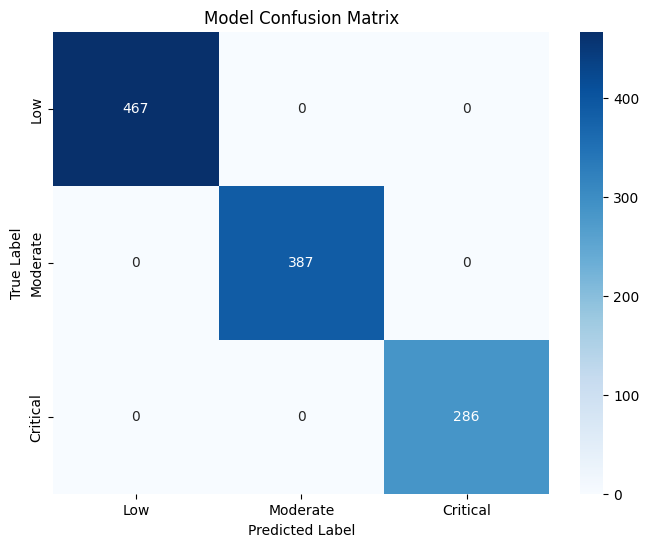


💾 Saving model artifacts...
✅ Model saved!


In [3]:
# 3. Train High-Accuracy Model with Visualization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the robust dataset
df = pd.read_csv('../analysis/results/training_data_robust.csv')

print("🔧 Preprocessing Data...")
le_drug = LabelEncoder()
le_symptom = LabelEncoder()

# Fit encoders
df['drug_encoded'] = le_drug.fit_transform(df['drug'])
df['symptom_encoded'] = le_symptom.fit_transform(df['symptom'])

X = df[['drug_encoded', 'symptom_encoded', 'faers_reports']]
y = df['label']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("\n🔍 Starting Grid Search for Best Model...")
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=1,
    scoring='f1_weighted'
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"\n🏆 Best Parameters: {grid_search.best_params_}")

# Evaluation
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'Critical']))

# Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Moderate', 'Critical'],
            yticklabels=['Low', 'Moderate', 'Critical'])
plt.title('Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save Artifacts
print("\n💾 Saving model artifacts...")
joblib.dump(best_model, '../models/risk_classifier.pkl')
joblib.dump(le_drug, '../models/drug_encoder.pkl')
joblib.dump(le_symptom, '../models/symptom_encoder.pkl')
print("✅ Model saved!")

In [4]:
# 4. Sanity Check: Test with Real Examples
def predict_risk(drug, symptom):
    try:
        # Load artifacts (simulating production load)
        model = joblib.load('../models/risk_classifier.pkl')
        le_drug = joblib.load('../models/drug_encoder.pkl')
        le_symptom = joblib.load('../models/symptom_encoder.pkl')
        
        # Check if known
        if drug not in le_drug.classes_ or symptom not in le_symptom.classes_:
            return "Unknown Drug/Symptom"
            
        # Encode
        d_enc = le_drug.transform([drug])[0]
        s_enc = le_symptom.transform([symptom])[0]
        
        # We need the report count for the model. 
        # In production, we fetch this live. Here we'll simulate a lookup from our training data.
        # If not in data, we assume 0 for this test.
        match = df[(df['drug'] == drug) & (df['symptom'] == symptom)]
        reports = match.iloc[0]['faers_reports'] if not match.empty else 0
        
        # Predict
        pred = model.predict([[d_enc, s_enc, reports]])[0]
        probs = model.predict_proba([[d_enc, s_enc, reports]])[0]
        
        levels = ['Low', 'Moderate', 'Critical']
        return f"{levels[pred]} (Conf: {probs.max():.2f}, Reports: {reports})"
        
    except Exception as e:
        return f"Error: {e}"

print("🧪 Running Sanity Checks...")
test_cases = [
    ("warfarin", "bleeding"),           # Should be Critical
    ("lisinopril", "cough"),            # Should be Moderate/Critical
    ("ibuprofen", "headache"),          # Should be Low/Moderate
    ("atorvastatin", "rhabdomyolysis"), # Should be Critical
    ("amoxicillin", "rash")             # Should be Moderate
]

for d, s in test_cases:
    print(f"Checking {d} + {s}: {predict_risk(d, s)}")

🧪 Running Sanity Checks...
Checking warfarin + bleeding: Unknown Drug/Symptom
Checking lisinopril + cough: Critical (Conf: 0.99, Reports: 8425)
Checking ibuprofen + headache: Critical (Conf: 0.99, Reports: 12345)
Checking atorvastatin + rhabdomyolysis: Critical (Conf: 0.96, Reports: 3962)
Checking amoxicillin + rash: Critical (Conf: 0.97, Reports: 5058)


C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have 